In [22]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   float64
 10  BloodPressure_0           2887 non-null   float64
 11  SkinThickness_0           1234 non-null   float64
 12  Insulin_0                 256 non-null    float64
 13  Pregnancies_0             2570 non-null   float64
 14  SkinThic

In [24]:
train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
0,200,9,125,74,0,0,28.536910,0.444902,45,1.0,...,0,0.200000,26.875,74.0,135.636364,3-,0,0,0,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0.0,...,0,0.181818,26.875,80.0,135.636364,-3,0,0,1,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0.0,...,0,0.153846,39.000,78.0,135.636364,-3,0,0,1,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0.0,...,0,0.200000,26.875,74.0,135.636364,3-,0,0,0,1
4,3644,5,107,78,44,284,52.935068,0.284959,45,1.0,...,0,0.111111,44.000,78.0,284.000000,-3,0,0,1,0


In [51]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'SkinThickness',
                 'BloodPressure',
                 'BloodPressure_na',
                 'Insulin_na',
                 'Insulin_dpf_mean',
                 
                 'Pregnancies_bin_0',
                  
              
                 
                
                      
                
                 
             ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [52]:
X_train.columns

Index(['DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'SkinThickness', 'BloodPressure', 'BloodPressure_na', 'Insulin_na',
       'Insulin_dpf_mean', 'Pregnancies_bin_0'],
      dtype='object')

In [53]:
print(X_train.shape, y_train.shape, id_train.shape)

(3000, 11) (3000, 1) (3000, 1)


ベースライン評価のため一部データを分ける。

残りのデータでvalidationしてその条件・目的変数・validation方法・評価指標を仮定し評価する。

上記3項目を明確にすることをベースラインの決定とする。

validationした後にベースライン評価のためのデータで評価しベースラインを検証する。

validation時とベースライン検証時の結果の傾向に大きな差が無ければベースラインの3項目は問題ないと判断する。

ベースラインが決定すると、その後EDAやモデル改善後はvalidationのみを行い進めていく。
（変更点や結果を記録）

## validation方法（ベースライン作成へ）

clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_test, y_test))

In [54]:
random_state = 123
params = {'random_state': random_state,
          'criterion': 'gini',

    }

#https://qiita.com/FujiedaTaro/items/61ded4ea5643a6204317#

In [76]:
# cvでの評価用
def train_rf(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
                         
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = RandomForestClassifier(**params_best)
        model.fit(x_tr,
                  y_tr,
                )
        # モデルの保存
        fname_rf = 'model/rf/model_rf_fold{}.pickle'.format(nfold)
        with open(fname_rf, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0).astype(int))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0).astype(int))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [77]:
train_oof, imp, metrics = train_rf(X_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

-------------------- 0 --------------------
(2400, 11) (2400, 1)
(600, 11) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[accuracy] tr: 1.00, va: 0.813333
-------------------- 1 --------------------
(2400, 11) (2400, 1)
(600, 11) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[accuracy] tr: 1.00, va: 0.803333
-------------------- 2 --------------------
(2400, 11) (2400, 1)
(600, 11) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238
[accuracy] tr: 1.00, va: 0.785000
-------------------- 3 --------------------
(2400, 11) (2400, 1)
(600, 11) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238
[accuracy] tr: 1.00, va: 0.816667
-------------------- 4 --------------------
(2400, 11) (2400, 1)
(600, 11) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.238
[accuracy] tr: 1.00, va: 0.795000
-------------------- result --------------------
[[0.         1.         0.81333333]
 [1.         1.         0.80333333]
 [2.         1.         0.785     ]
 [3.         1.         0.81666667]
 [4.         1.         0.795   

In [78]:
imp.sort_values('imp', ascending=False)

,col,imp,imp_std
1,BMI,0.224934,0.003747
4,DiabetesPedigreeFunction,0.169187,0.001921
0,Age,0.163364,0.009416
5,Glucose,0.136197,0.003054
2,BloodPressure,0.103606,0.002065
8,Pregnancies,0.094409,0.003158
10,SkinThickness,0.062712,0.001090
6,Insulin_dpf_mean,0.021897,0.001323
7,Insulin_na,0.009559,0.000388
9,Pregnancies_bin_0,0.009396,0.000193


In [79]:
train_oof

,index,pred
0,200,0.442568
1,3832,0.057432
2,4927,0.530405
3,4088,0.628378
4,3644,0.847973
...,...,...
2995,4931,0.209459
2996,3264,0.043919
2997,1653,0.280405
2998,2607,0.395270


###

'DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'BloodPressure_na', 'BloodPressure_0', 'SkinThickness', 'Insulin_0' 'Insulin_na' 
       
       
'SkinThickness_na' or 'SkinThickness'
###

In [80]:
X_train.columns

Index(['DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'SkinThickness', 'BloodPressure', 'BloodPressure_na', 'Insulin_na',
       'Insulin_dpf_mean', 'Pregnancies_bin_0'],
      dtype='object')

## 推論

In [81]:
def predict_rf(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_rf = 'model/rf/model_rf_fold{}.pickle'.format(nfold)
        with open(fname_rf, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [82]:
test_pred_proba = predict_rf(X_test,
                    id_test,
                    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [83]:
test_pred_proba[:3]

,index,pred
0,398,0.332432
1,3833,0.092568
2,4836,0.032432


In [84]:
test_pred = test_pred_proba.copy()  
test_pred['pred']=np.where(test_pred['pred'] < 0.5, 0, 1)
test_pred[:3]

,index,pred
0,398,0
1,3833,0
2,4836,0


In [85]:
train_oof[:3]

,index,pred
0,200,0.442568
1,3832,0.057432
2,4927,0.530405


In [87]:
test_pred.to_csv('ensamble/sub/submission_rf.csv', index=None, header=False,)

## アンサンブル用データ

In [88]:
import pickle
 
with open('ensamble/rf_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/rf_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン検証

### 初めに検討し問題なければ、その後はスキップ可能

ベースライン（評価指標や検証法、特徴量選択）の評価を行う

① 検証データの評価値とベースライン評価値のギャップが小さいか確認

② 後分類の傾向が似ているか確認

③ 予測値の分布が似ているか確認

上記3点が問題なければ、ベースラインを決定し、EDAやモデル改善を行う。

In [89]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (2400, 11) (2400, 1)
ベースライン検証データ:  (600, 11) (600, 1)
検証データ(train):  (1920, 11) (1920, 1)
検証データ(test):  (480, 11) (480, 1)


In [90]:
#validation結果
model = RandomForestClassifier(**params_best)
model.fit(x_tr1,
          y_tr1,
         )

RandomForestClassifier(max_depth=38, max_features='auto', n_estimators=296,
                       random_state=123)

In [91]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, y_va2_pred)))

y_va1_pred_proba = model.predict_proba(x_va1)
y_va2_pred_proba = model.predict_proba(x_va2)
print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred_proba[:,1])))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred_proba[:,1])))


[検証データ] acc: 0.7792
[ベースライン検証データ] acc: 0.7883
[検証データ] auc: 0.7610
[ベースライン検証データ] auc: 0.8255


In [92]:
#後分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[344  21]
 [ 85  30]]
[[0.71666667 0.04375   ]
 [0.17708333 0.0625    ]]
ベースライン検証データ
[[428  29]
 [ 98  45]]
[[0.71333333 0.04833333]
 [0.16333333 0.075     ]]


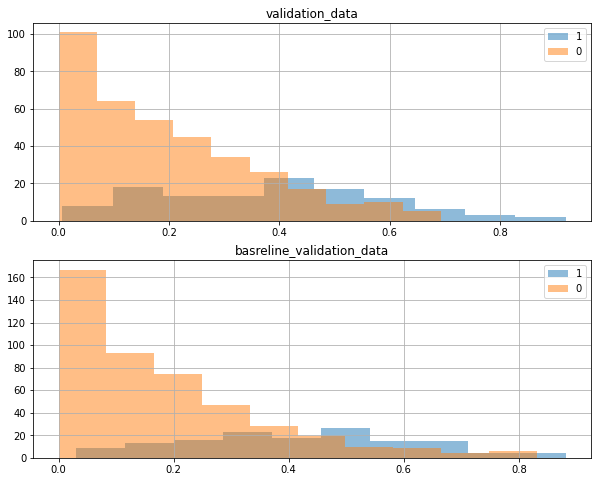

In [93]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

## チューニング

In [71]:
import optuna

          'min_samples_split': 2,
          'min_samples_leaf': 1,
          'verbose': 1,
          'n_estimators': 10, 
          'max_depth': None,
          'min_weight_fraction_leaf': 0,
          'max_features': 'auto',
          'max_leaf_nodes': None,
          'min_impurity_decrease': 0,
          'bootstrap': True,
          'oob_score': False,
          'n_jobs': None,
          'warm_start': False,
          'class_weight': None

In [72]:
# 探索しないパラメータ

params_base = {
    'criterion': 'gini',
    'n_jobs':None,
    'random_state': 123,
    'max_features': 'auto'
}

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'n_estimators': trial.suggest_int('n_estimators',50,500),
        'max_depth': trial.suggest_int('max_depth',1,100),
        # 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 'auto', None])
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
        
         }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(X_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
        
        model = RandomForestClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [73]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-21 09:53:00,151] A new study created in memory with name: no-name-5a57eff8-79f8-467f-858a-82310194d86f
[I 2023-03-21 09:53:02,838] Trial 0 finished with value: 0.7963333333333333 and parameters: {'n_estimators': 364, 'max_depth': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7963333333333333.
[I 2023-03-21 09:53:05,548] Trial 1 finished with value: 0.798 and parameters: {'n_estimators': 374, 'max_depth': 43, 'criterion': 'gini'}. Best is trial 1 with value: 0.798.
[I 2023-03-21 09:53:07,485] Trial 2 finished with value: 0.7976666666666666 and parameters: {'n_estimators': 266, 'max_depth': 40, 'criterion': 'entropy'}. Best is trial 1 with value: 0.798.
[I 2023-03-21 09:53:08,660] Trial 3 finished with value: 0.79 and parameters: {'n_estimators': 247, 'max_depth': 6, 'criterion': 'entropy'}. Best is trial 1 with value: 0.798.
[I 2023-03-21 09:53:09,615] Trial 4 finished with value: 0.7953333333333334 and parameters: {'n_estimators': 132, 'max_depth': 18, 'criterio

In [74]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.7987


{'n_estimators': 296, 'max_depth': 38, 'criterion': 'gini'}

In [75]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'n_estimators': 296,
 'max_depth': 38,
 'criterion': 'gini',
 'n_jobs': None,
 'random_state': 123,
 'max_features': 'auto'}